In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

In [2]:
from tqdm.notebook import tqdm

In [114]:
path = './Normal videos/Normal_Videos_345_x264.mp4'

In [77]:
video_file = cv2.VideoCapture(path)
print(video_file)

<VideoCapture 0x7fabe9626af0>


In [4]:
if not video_file.isOpened():
    print('Error reading video')

In [5]:

# Getting the frames per second
fps = video_file.get(cv2.CAP_PROP_FPS)

print("Frames per second:", fps)

Frames per second: 30.0


## Saving files

In [23]:
normal_frames_directory = './normal_frames'
# os.makedirs(normal_frames_directory, exist_ok=True)

In [116]:
# video_file = cv2.VideoCapture(path)
# print(video_file)

<VideoCapture 0x7fecc1568950>


In [24]:
#Script to delete files

files_in_directory = os.listdir(normal_frames_directory)
for file in files_in_directory:
    file_path = os.path.join(normal_frames_directory, file)
    # print(file_path)
    
    # remove (delete) the file
    if file_path != './normal_frames/.ipynb_checkpoints':
        # print('yes')
        os.remove(file_path)


## Modular Approach

In [3]:
# video_file = cv2.VideoCapture(path)
# print(video_file)

<VideoCapture 0x7fecc17f0310>


In [25]:
def get_threshold_frames(threshold, difference_dict):
    significant_changes = []

    for key, value in difference_dict.items():
        mean_difference = np.mean(value)
        # print(mean_difference)

        if mean_difference > threshold:
            significant_changes.append(key)
    
    return significant_changes
    

In [26]:
def get_significant_average_frame_keys(key_list):
    
    average_keys_with_significant_changes = set()
    for key in key_list:
        average_keys_with_significant_changes.add(key)
        average_keys_with_significant_changes.add(key + 1)
    return average_keys_with_significant_changes
    

In [27]:
def get_frame_number_from_average_dict_key(key):
    end_frame_number = key * 30
    begin_frame_number = (end_frame_number - 30) + 1
    return begin_frame_number, end_frame_number

In [28]:
def convert_to_gray(img):
    converted_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    return converted_gray

In [29]:
def get_frames_in_range(begin, end):
    indexes = []
    for i in range(begin, end + 1):
        indexes.append(i)
    return indexes

In [30]:
def populate_normal_frames_from_frame_number(frame_numbers_list, original_frames_dict):
    original_frames = []
    for number in frame_numbers_list:
        original_frames.append(original_frames_dict[number])
    
    return original_frames

In [31]:
def get_original_frame_numbers(average_image_keys):
    frame_numbers_list = []
    for key in average_image_keys:
        begin_index, end_index = get_frame_number_from_average_dict_key(key)
        frame_numbers = get_frames_in_range(begin_index, end_index)
        frame_numbers_list.extend(frame_numbers)
    return frame_numbers_list
    

In [32]:
def get_difference_dict(average_frames_dict):
    
    difference_frames_dict = {}
    for i in range(1, len(average_frames_dict)):
        difference = average_frames_dict[i] -  average_frames_dict[i + 1]
        difference_frames_dict[i] = difference
    return difference_frames_dict


In [33]:
# original_frames_dict = {}
# average_frames_dict = {}
# difference_frames_dict = {}

In [34]:
def get_video_change_frames(video_file):
    
    original_frames_dict = {}
    average_frames_dict = {}
    difference_frames_dict = {}
    
    frame_sum = None
    average_frames = []
    seconds_counter = 0
    frame_counter = 0
    total_frames = 0

    while True:
        ret, frame = video_file.read()

        #If the end of frames or any error in reading
        if not ret:
            break

        total_frames += 1

        original_frames_dict[total_frames] = frame

        #converting to grayscale
        image = convert_to_gray(frame)

        #Summing frames for averaging later
        if frame_sum is None:
            frame_sum = image.astype('float64')
        else:
            frame_sum += image.astype('float64')

        frame_counter += 1

        if frame_counter == 30:
            seconds_counter += 1
            average_frame = frame_sum / frame_counter
            average_frames_dict[seconds_counter] = average_frame
            average_frames.append(average_frame)
            frame_sum = None
            frame_counter = 0

    video_file.release()
    cv2.destroyAllWindows()
    
    difference_frames_dict = get_difference_dict(average_frames_dict)
    
    difference_keys_with_significant_changes = get_threshold_frames(0.05, difference_frames_dict)
    
    average_keys_with_significant_changes = \
    get_significant_average_frame_keys(difference_keys_with_significant_changes)
    
    frame_numbers_to_consider = \
    get_original_frame_numbers(average_keys_with_significant_changes)
    
    normal_frames_for_training = \
    populate_normal_frames_from_frame_number(frame_numbers_to_consider, original_frames_dict)
    
    return normal_frames_for_training
    
        

In [35]:
def populate_training_dataset():
    
    training_dataset = []
    
    normal_videos_path = './Normal videos'

    files_in_directory = os.listdir(normal_videos_path)
    for file in tqdm(files_in_directory, desc = 'Reading Normal Videos'):
        file_path = os.path.join(normal_videos_path, file)

        #Reading Video
        if file_path == './Normal videos/.ipynb_checkpoints':
            continue
        video_file = cv2.VideoCapture(file_path)
        frames_from_video = get_video_change_frames(video_file)
        training_dataset.extend(frames_from_video)
    
    return training_dataset

In [36]:
training_frames_dataset = populate_training_dataset()

Reading Normal Videos:   0%|          | 0/26 [00:00<?, ?it/s]

In [37]:
print(len(training_frames_dataset))

42210


### Saving Original Frames for Training

In [38]:
normal_frames_directory = './normal_frames'
os.makedirs(normal_frames_directory, exist_ok=True)

In [39]:
count = 0
for frame in tqdm(training_frames_dataset, desc = 'Saving original frames'):
    count += 1
    cv2.imwrite(f'{normal_frames_directory}/frame_{count}.png', frame)
     

Saving original frames:   0%|          | 0/42210 [00:00<?, ?it/s]

**Using Average Technique**

In [92]:
video_file = cv2.VideoCapture(path)
print(video_file)

<VideoCapture 0x7fecc131d190>


In [93]:
def convert_to_gray(img):
    converted_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    return converted_gray

In [94]:
original_frames = []

In [95]:
frame_sum = None
average_frames = []
frame_counter = 0
total_frames = 0

while True:
    ret, frame = video_file.read()
    
    #If the end of frames or any error in reading
    if not ret:
        break
    
    total_frames += 1
    
    original_frames.append(frame)
        
    #converting to grayscale
    image = convert_to_gray(frame)
    
    #Summing frames for averaging later
    if frame_sum is None:
        frame_sum = image.astype('float64')
    else:
        frame_sum += image.astype('float64')
    
    frame_counter += 1
    
    if frame_counter == 30:
        average_frame = frame_sum / frame_counter
        average_frames.append(average_frame)
        frame_sum = None
        frame_counter = 0
     
video_file.release()
cv2.destroyAllWindows()   
    
    
        

In [96]:
print(f'Total frames : {total_frames}')

Total frames : 305


In [97]:
print(len(average_frames))

10


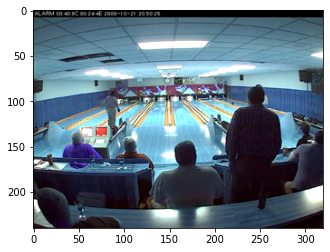

In [98]:
frame_to_display = original_frames[-1]
plt.imshow(frame_to_display)
plt.show()

In [106]:
new_differences_list = []

In [107]:
for i in range(len(average_frames) - 1):
    difference = average_frames[i] -  average_frames[i + 1]
    new_differences_list.append(difference)

In [108]:
print(len(new_differences_list))

9


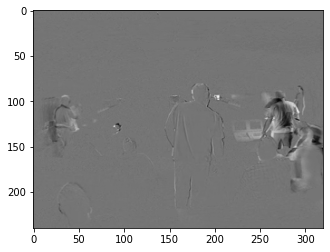

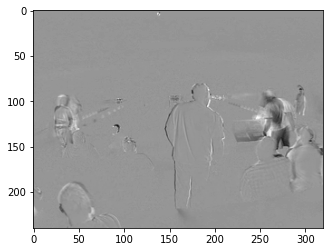

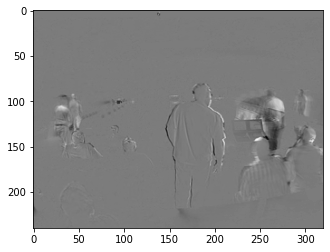

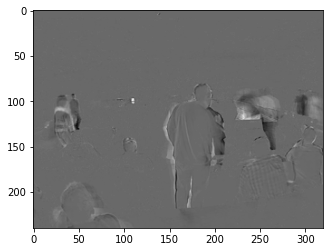

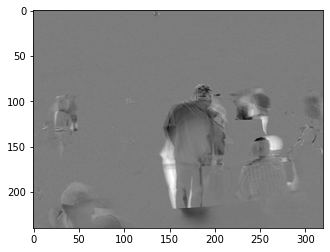

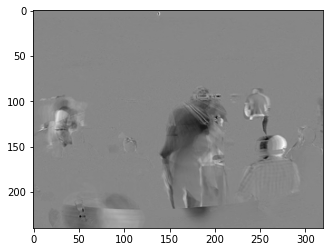

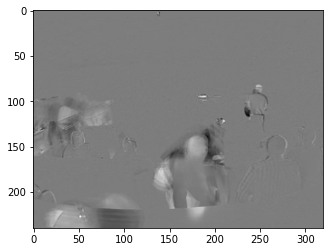

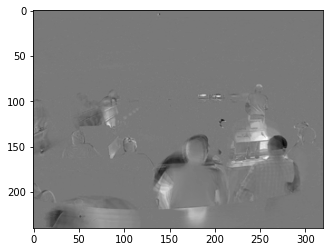

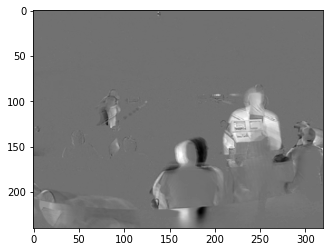

In [109]:
for item in new_differences_list:
    plt.imshow(item, cmap='gray')
    plt.show()

**Thresholding**

In [103]:
threshold = 0.2

significant_changes = []

for i in range(len(new_differences_list)):
    
    mean_difference = np.mean(new_differences_list[i])
    print(mean_difference)
    
    if mean_difference > threshold:
        significant_changes.append(new_differences_list[i])
        
    

0.3599453125
1.0663758680555557
0.7632096354166665
0.3631818576388892
1.5121909722222218
4.925748697916666
-0.19754166666666667
-1.591359375
-5.466342881944445


In [90]:
print(len(significant_changes))

0


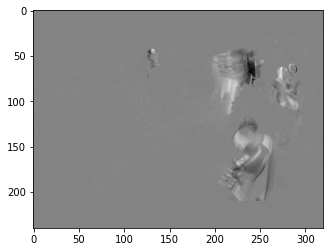

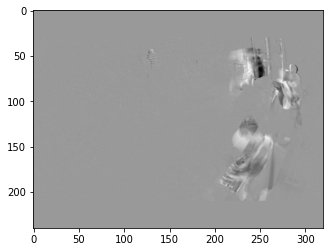

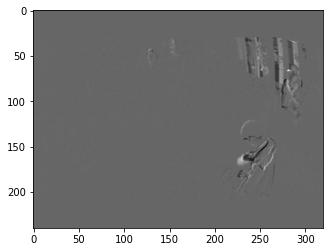

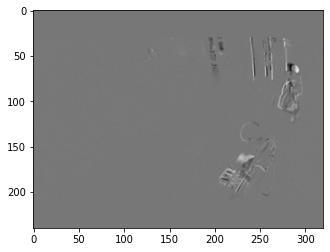

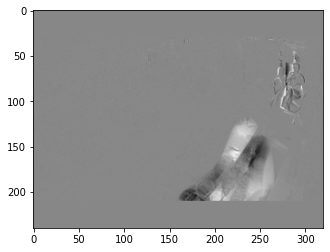

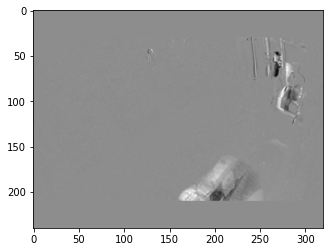

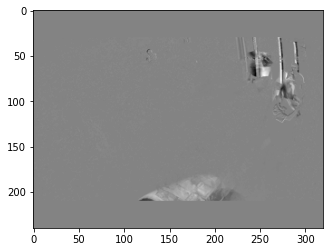

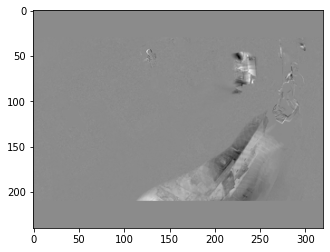

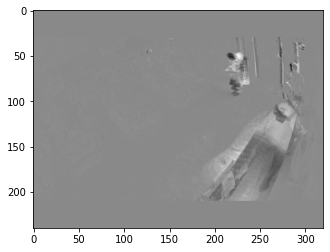

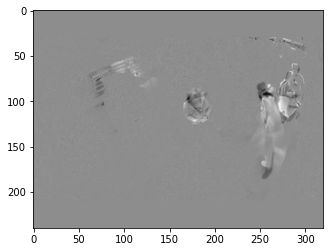

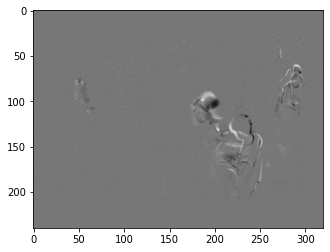

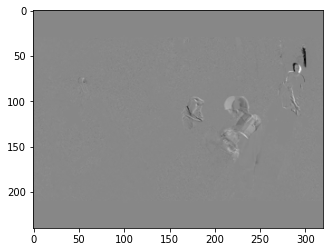

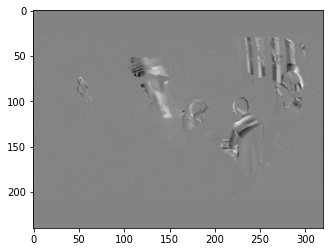

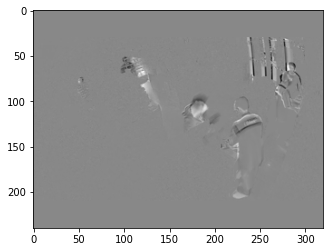

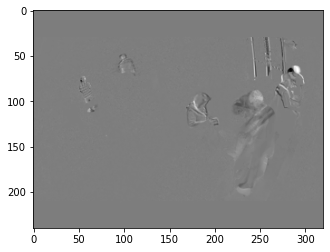

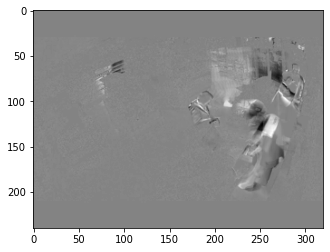

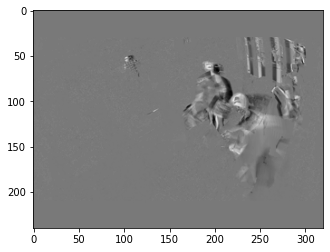

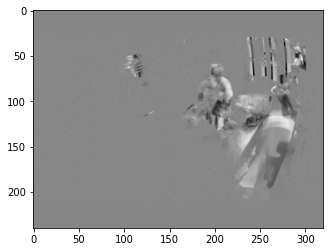

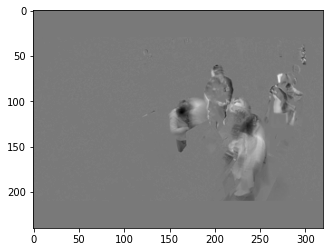

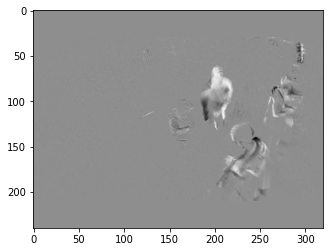

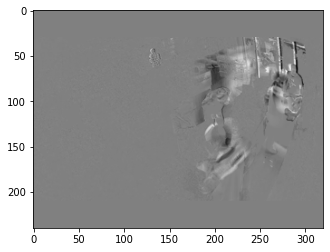

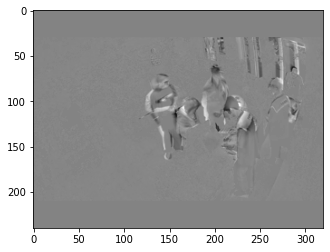

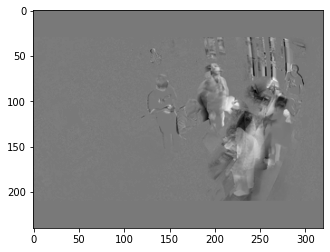

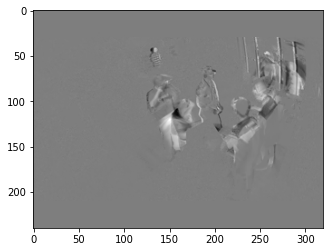

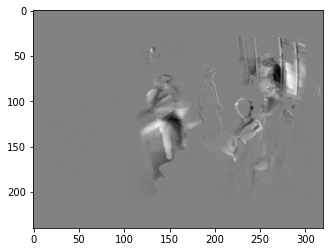

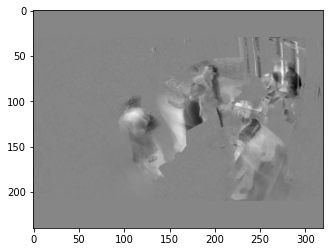

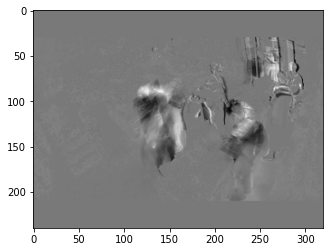

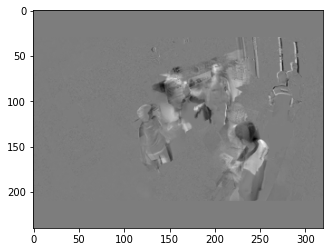

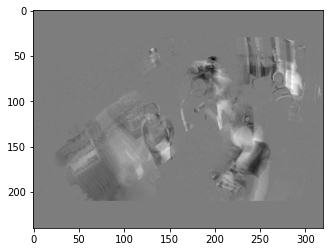

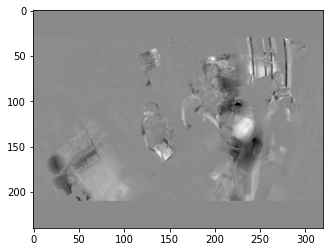

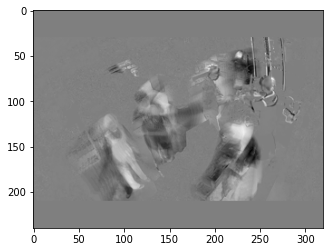

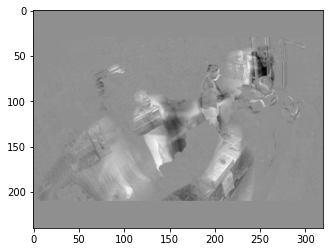

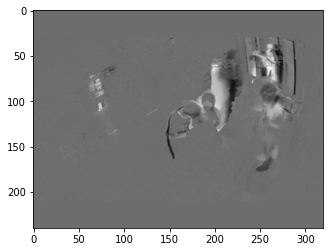

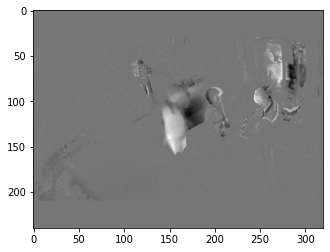

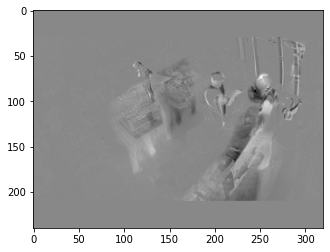

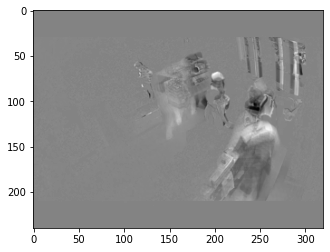

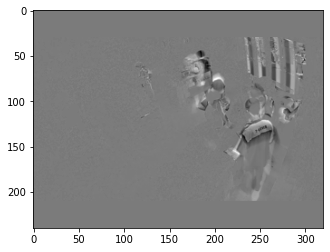

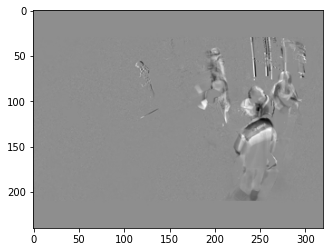

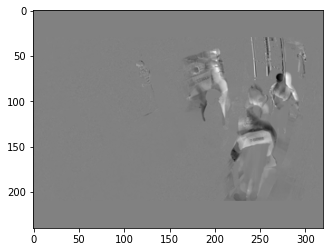

In [76]:
for item in significant_changes:
    plt.imshow(item, cmap='gray')
    plt.show()